

# Discrete functional decoding

Perform meta-analytic functional decoding on regions of interest.

We can use the methods in ``nimare.decode.discrete`` to apply functional
characterization analysis to regions of interest or subsets of the Dataset.


In [25]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import nimare
import nibabel as nib
from nimare.stats import pearson
from nimare.dataset import Dataset
from nimare.decode import discrete
from nimare.utils import get_resource_path
from nimare.extract import fetch_neurosynth
from nimare.io import convert_neurosynth_to_dataset
from nimare.decode import continuous
from nilearn import image
from nilearn.plotting import plot_roi


## Load dataset with abstracts
We'll load a small dataset composed only of studies in Neurosynth with
Angela Laird as a coauthor, for the sake of speed.



In [13]:
dset = Dataset(os.path.join(get_resource_path(), "neurosynth_laird_studies.json"))
dset.annotations.head(5)

,id,study_id,contrast_id,Neurosynth_TFIDF__001,Neurosynth_TFIDF__01,Neurosynth_TFIDF__05,Neurosynth_TFIDF__10,Neurosynth_TFIDF__100,Neurosynth_TFIDF__11,Neurosynth_TFIDF__12,...,Neurosynth_TFIDF__yield,Neurosynth_TFIDF__yielded,Neurosynth_TFIDF__young,Neurosynth_TFIDF__young adults,Neurosynth_TFIDF__young healthy,Neurosynth_TFIDF__young older,Neurosynth_TFIDF__younger,Neurosynth_TFIDF__younger adults,Neurosynth_TFIDF__youth,Neurosynth_TFIDF__zone
0,17029760-1,17029760,1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,18760263-1,18760263,1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,19162389-1,19162389,1,0.0,0.0,0.0,0.0,0.0,0.176321,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,19603407-1,19603407,1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20197097-1,20197097,1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Create a region of interest
### 创建ROI图像

根据元分析结果得到的解剖区域创建ROI。

疾病组： 创建一个brain mask：
- Frontal pole （-6，58，18）

健康组： 创建五个brain mask
- Paracingulate Gyrus （0，48，8）
- Frontal Orbital Cortex （-38，24，-14）
- Cingulate Gyrus posterior division （-2，-54，26）
- Angular Gyrus （-44, -58，24）
- Frontal Orbital Cortex （32， 18, -18）

In [ ]:
# 加载target image，作为输入数据
target_img = sys.argv[1]  
target_img

'--f=/Users/ss/Library/Jupyter/runtime/kernel-v354253902236115df08a7737a5959e2ba15c97425.json'

In [23]:
data_dir = os.path.abspath("results/demo/data")
result_dir = os.path.abspath("results/demo/results")

In [29]:
files = fetch_neurosynth(
    data_dir=data_dir,
    version="7",
    overwrite=False,
    source="abstract",
    vocab="terms",
)

neurosynth_db = files[0]
neurosynth_dset = convert_neurosynth_to_dataset(
    coordinates_file=neurosynth_db["coordinates"],
    metadata_file=neurosynth_db["metadata"],
    annotations_files=neurosynth_db["features"],
)

neurosynth_dset.save(os.path.join(data_dir, "neurosynth_dataset.pkl.gz"))

INFO:nimare.extract.utils:Dataset created in /Users/ss/Documents/psych_self_meta/code/results/demo/data/neurosynth
INFO:nimare.extract.extract:Searching for any feature files matching the following criteria: [('source-abstract', 'vocab-terms', 'data-neurosynth', 'version-7')]


In [31]:
meta_result_files = np.genfromtxt(os.path.join(data_dir, "psychosis_terms_meta-analysis_maps_list.txt"), comments=None, delimiter="None", dtype="str")


FileNotFoundError: /Users/ss/Documents/psych_self_meta/code/results/demo/data/psychosis_terms_meta-analysis_maps_list.txt not found.

In [9]:
# 加载 控制组的 Z 值图像
z_img_controls = image.load_img('../results/ale/control_all_z.nii.gz')

# 设置阈值，选择激活区域
# Z>3.1 对应 P<0.001
threshold = 3.1
z_data = z_img_controls.get_fdata()

# 创建一个二进制掩模，只选择 Z 值大于阈值的区域
roi_img = np.where(z_data > threshold, 1, 0)


In [11]:

# 生成新的 ROI 图像
# roi_img_controls = image.new_img_like(z_img_controls, roi_img)
roi_img_controls = image.new_img_like(z_img_controls, roi_img)


/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_13499/1579018439.py:3: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  roi_img_controls = image.new_img_like(z_img_controls, roi_img)


In [14]:
# 绘制ROI图像，不显示十字线
mask_img = nib.Nifti1Image(roi_img_controls, dset.masker.mask_img.affine)


In [ ]:
plot_roi(roi_img_controls, draw_cross=False)

# 可视化 ROI 图像
plot_roi(roi_img_controls)

In [16]:
dataset_affine = dset.masker.mask_img.affine

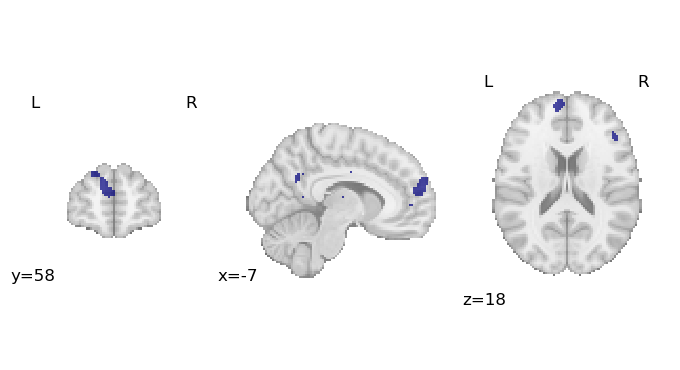

In [ ]:

# # 创建ROI图像，图像仅含0和1两个值，1表示ROI区域
# arr = np.zeros(dset.masker.mask_img.shape, np.int32)
# arr[65:75, 50:60, 50:60] = 1




In [15]:

# Get studies with voxels in the mask
# 获取在roi内所有体素的研究
ids = dset.get_studies_by_mask(roi_img_controls)

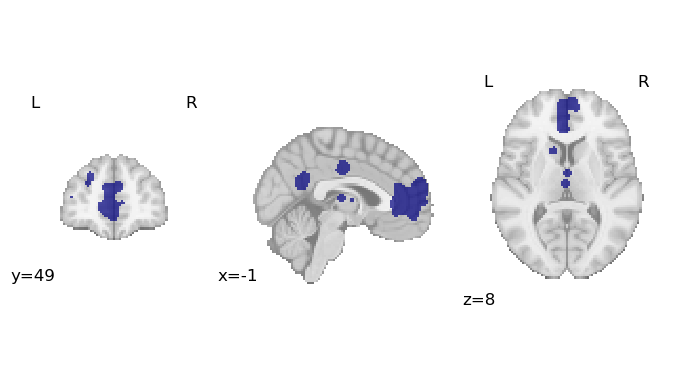

In [24]:
# mask_img = nib.Nifti1Image(arr, dset.masker.mask_img.affine)
plot_roi(roi_img_controls, draw_cross=False)

# Get studies with voxels in the mask
# 获取在roi内所有体素的研究
ids_controls = dset.get_studies_by_mask(roi_img_controls)

In [29]:
# Get studies with voxels in the mask
# 获取在roi内所有体素的研究
ids_patients = dset.get_studies_by_mask(roi_img_patients)


## Decode an ROI image using the Neurosynth chi-square method



对研究ID列表进行解码，适用于需要分析特定研究集合的情况，输出与研究ID相关的特征。

In [25]:
# Run the decoder
# 创建一个解码器，用于将研究的结果转换为概率
decoder = discrete.NeurosynthDecoder(correction=None)
# 进行拟合
decoder.fit(dset)
# 进行解码，对在指定ROI内的研究ID列表（ids）进行解码,返回一个DataFrame（decode_df）
decoded_df = decoder.transform(ids=ids_controls)

decoded_df.sort_values(by="probReverse", ascending=False).head(10)

INFO:nimare.decode.base:Retaining 728/3228 features.


,pForward,zForward,probForward,pReverse,zReverse,probReverse
Term,,,,,,
Neurosynth_TFIDF__affective,0.000003,4.700003,0.818182,0.091195,1.689126,0.611111
Neurosynth_TFIDF__human,0.000003,4.700003,0.818182,0.091195,1.689126,0.611111
Neurosynth_TFIDF__functions,0.000003,4.700003,0.818182,0.091195,1.689126,0.611111
Neurosynth_TFIDF__analyses,0.000003,4.700003,0.818182,0.091195,1.689126,0.611111
Neurosynth_TFIDF__prefrontal,0.000140,3.808801,0.833333,0.139861,1.476309,0.600000
Neurosynth_TFIDF__provide,0.003582,2.912809,0.846154,0.204567,1.268648,0.590909
Neurosynth_TFIDF__lateral,0.003582,2.912809,0.846154,0.204567,1.268648,0.590909
Neurosynth_TFIDF__structure,0.003582,2.912809,0.846154,0.204567,1.268648,0.590909
Neurosynth_TFIDF__function,0.003582,2.912809,0.846154,0.204567,1.268648,0.590909


In [1]:
decoder = discrete.NeurosynthDecoder(correction=None)
# 进行拟合
decoder.fit(dset)
# 进行解码，对在指定ROI内的研究ID列表（ids）进行解码,返回一个DataFrame（decode_df）
decoded_df = decoder.transform(ids=ids_patients)

decoded_df.sort_values(by="probReverse", ascending=False)

NameError: name 'discrete' is not defined


## Decode an ROI image using the Neurosynth ROI association method



直接对ROI图像进行解码，适用于需要直接分析特定脑区的情况，输出与ROI相关的特征。

In [13]:
# This method decodes the ROI image directly, rather than comparing subsets of the Dataset like the
# other two.
decoder = discrete.ROIAssociationDecoder(roi_img)
decoder.fit(dset)

# The `transform` method doesn't take any parameters.
decoded_df = decoder.transform()

decoded_df.sort_values(by="r", ascending=False).head()

INFO:nimare.decode.base:Retaining 728/3228 features.


,r
feature,
Neurosynth_TFIDF__reward,0.723187
Neurosynth_TFIDF__hippocampus,0.682885
Neurosynth_TFIDF__ofc,0.682885
Neurosynth_TFIDF__striatum,0.682885
Neurosynth_TFIDF__involving,0.682885


In [ ]:
self_subj = nib.load('xxx')
out_dir = os.path.abspath('xxx')  
os.makedirs(out_dir, exist_ok=True)

files = fetch_neurosynth(
    data_dir=out_dir,
    version="7",
    overwrite=False,
    source="abstract",
    vocab="terms",
)

neurosynth_db = files[0]
neurosynth_dset = convert_neurosynth_to_dataset(
    coordinates_file=neurosynth_db["coordinates"],
    metadata_file=neurosynth_db["metadata"],
    annotations_files=neurosynth_db["features"],
)
neurosynth_dset.save(os.path.join(out_dir, "neurosynth_dataset.pkl.gz"))

import nimare
neurosynth_dset = nimare.dataset.Dataset.load(os.path.join(out_dir, "neurosynth_dataset.pkl.gz"))
neurosynth_dset.update_path(out_dir)

# decoder = continuous.CorrelationDecoder(feature_group=None, features=None)


ale_estimator = ALE()
decoder = continuous.CorrelationDecoder(
    feature_group=None,
    features=None,
    meta_estimator=ale_estimator,
    target_image='z',
)


decoder.fit(neurosynth_dset)
decoded_df1 = decoder.transform(self_subj)
decoded_df1 = decoded_df1.sort_values(by='correlation', ascending=False)
print(decoded_df1)